In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T

#### Rat tumor example

We have 71 experiments, each one is governed by the following likelihood: <br><br>
$y_{j}$ $\sim$ Bin($n_{j}$, $\theta_{j}$), where $n_{j}$ is known constant. 

We have to specify a prior for the parameter of interest (probability of tumor)<br><br>
$\theta_{j}$ $\sim$ Beta($\alpha$, $\beta$)

If we stopped here and let $\alpha$ and $\beta$ be constants, it would imply that each $\theta_{i}$ is independent from others, only specified prior has the common form. So experiments would be independent and results of the one would not influence the inference for the other.
Graphically: 

($\theta_{i}$ -> $y_{i}$)  is repeated 71 times 

It's better, if the result of the one experiments convey some information further. We can do so in two ways.

$\textbf{First one}$, instead of introducing 71 $\theta$'s (or 71 random variable), keep only one. Each experiment treat as a realization of this random variable. So we can write 

$y_{j}$ $\sim$ Bin($n_{j}$, $\theta$) <br><br>
$\theta$ $\sim$ Beta($\alpha$, $\beta$)

It looks like standard inference problem, for example computing posteriof of mean of some process. 
Graphically:

$\theta$ -> ($y_{i}$) is repeated 71 times

One outcome of the experiment does influnce the inference of the others just as we wanted. The problem of this approach is that we have to specify some prior of $\theta$ and that is not so flexible. The another is the fact that each experiment has the same posterior of $\theta$. 

$\textbf{Second approach}$
Let prior of the common of distribution be picked by the data. (btw. $\theta$'s are independent given $\alpha$ and $\beta$). So as at the top, we can write: <br><br>
$y_{j}$ $\sim$ Bin($n_{j}$, $\theta_{j}$) <br><br>
$\theta_{j}$ $\sim$ Beta($\alpha$, $\beta$) <br><br>
But in this case $\alpha$ and $\beta$ are random variable. Graphically: <br><br>

$\alpha$, $\beta$ -> ($\theta_{i}$ -> $y_{i}$) is repeated 71 times 

In [10]:
y = np.array([
     0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
     1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
     5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])

n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])

N = len(n)

In [5]:
N

71

In the book, there is proposed noninformative hyperprior distribution of the form: <br><br>
p($\alpha$, $\beta$) $\propto$ $(\alpha + \beta)^{-5/2}$

In [11]:
with pm.Model() as model:
    ab = pm.DensityDist('ab',
                        lambda value: -2.5 * T.log(T.sum(value)),
                        shape=2,
                        testval=[1, 1])
    thetas = pm.Beta('thetas', alpha=ab[0], beta=ab[1], shape=N)
    ys = pm.Binomial('ys', p=thetas, observed=y, n=n)
    trace = pm.sample(1000, tune=5000)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas, ab]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:21<00:00, 1126.77draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5983332126924421, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


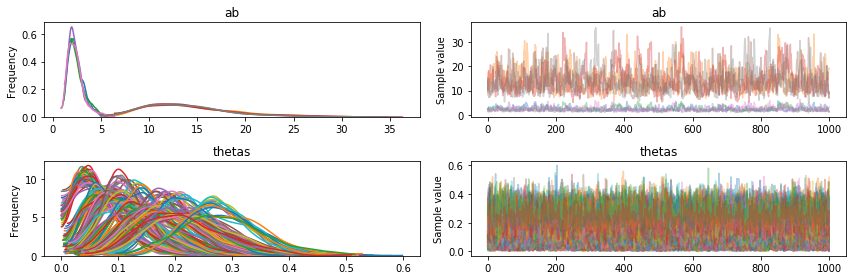

In [12]:
pm.traceplot(trace);

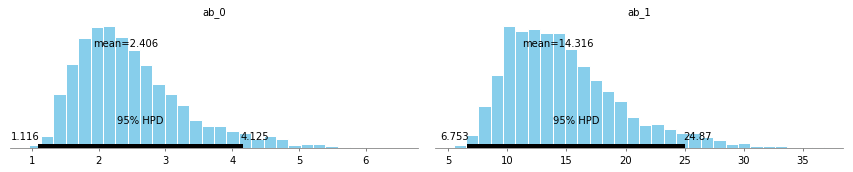

In [15]:
pm.plot_posterior(trace, varnames=['ab']);

In [16]:
# last experiment, raw estimate of theta
4 / 14

0.2857142857142857

In [17]:
trace.varnames

['ab', 'thetas_logodds__', 'thetas']

In [22]:
theta71 = trace['thetas'][:, 70]

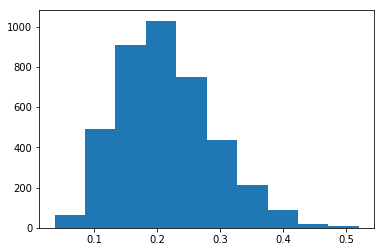

In [23]:
plt.hist(theta71);

In [24]:
# let's change hyperprior distribution just to see it the model will
# still be able to fit

In [26]:
with pm.Model() as model2:
    alpha = pm.Uniform('alpha', lower=1, upper=30)
    beta = pm.Uniform('beta', lower=1, upper=30)
    thetas = pm.Beta('thetas', alpha=alpha, beta=beta, shape=N)
    ys = pm.Binomial('ys', p=thetas, observed=y, n=n)
    trace = pm.sample(1000, tune=5000)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas, beta, alpha]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:22<00:00, 1056.66draws/s]
The acceptance probability does not match the target. It is 0.6917296212318119, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


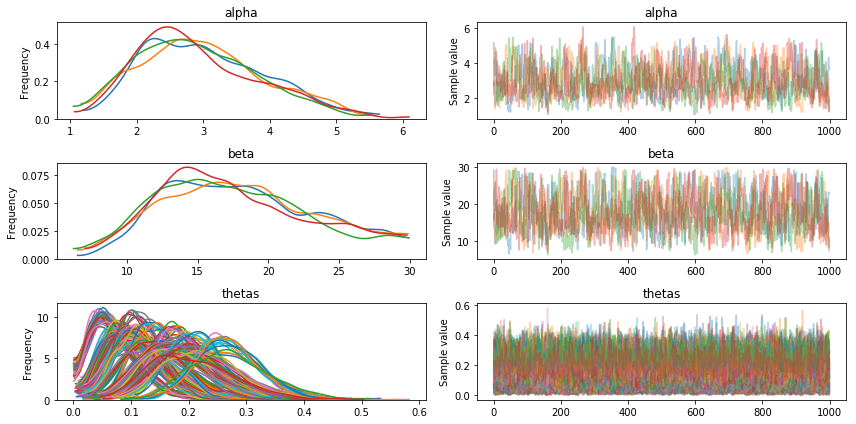

In [27]:
pm.traceplot(trace);

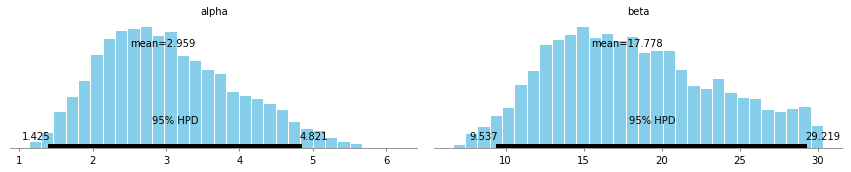

In [28]:
pm.plot_posterior(trace, varnames=['alpha', 'beta']);

In [29]:
theta71 = trace['thetas'][:, 70]

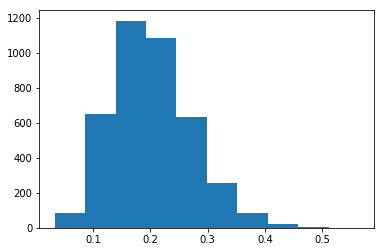

In [30]:
plt.hist(theta71);

#### Parallel experiments in eight schools

$y_{i}$ $\sim$ N($\theta_{i}$, $\sigma_{i}$), where $\sigma_{i}$ is known

$\theta_{i}$ $\sim$ N($\mu$, $\frac{1}{\tau^{2}}$)

p($\mu$, $\tau$) ~ prior($\mu$, $\tau$)

In [42]:
J = 8 # No. of schools
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])

with pm.Model() as model:
    mu = pm.Uniform('mu', lower=-100, upper=100)
    tau = pm.Uniform('tau', lower=1, upper=50)
    thetas = pm.Normal('thetas', mu=mu, sd=tau, shape=J)
    ys = pm.Normal('ys', mu=thetas, sd=sigma, observed=y)
    trace = pm.sample(1000, tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas, tau, mu]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:10<00:00, 1871.99draws/s]
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6389612229404413, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7002793797464999, but should be close to 0.8. Try to increase the number of tuning steps.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


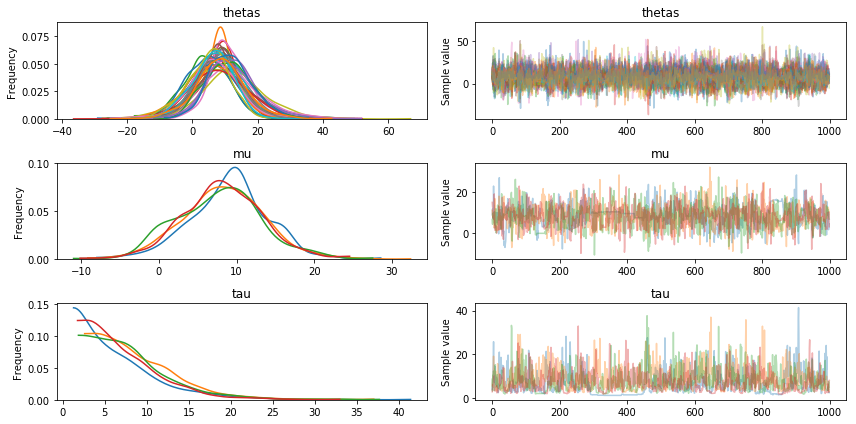

In [43]:
pm.traceplot(trace);

In [44]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
thetas__0,12.405374,8.791422,0.229336,-3.896616,30.934247,1476.973004,1.001614
thetas__1,8.308670,6.514488,0.159687,-4.574685,21.529093,1590.386083,1.000156
thetas__2,6.233223,8.203873,0.207040,-9.942652,23.166999,1421.710250,1.003898
thetas__3,7.823612,7.152682,0.165943,-6.296697,22.337702,1804.994010,1.002556
thetas__4,4.647666,6.888249,0.212619,-9.534114,17.048179,762.939202,1.007709
thetas__5,5.993284,7.075365,0.197563,-8.133796,19.529078,1065.100565,1.005157
thetas__6,11.528232,6.862498,0.197380,-1.625436,25.458731,1200.353008,1.000508
thetas__7,8.677574,8.366040,0.208663,-8.513245,24.981156,1662.269533,1.001781
mu,8.262713,5.292834,0.170670,-3.118781,17.817930,790.451898,1.005150
tau,7.654116,4.976983,0.226669,1.287669,17.034998,296.126859,1.018469


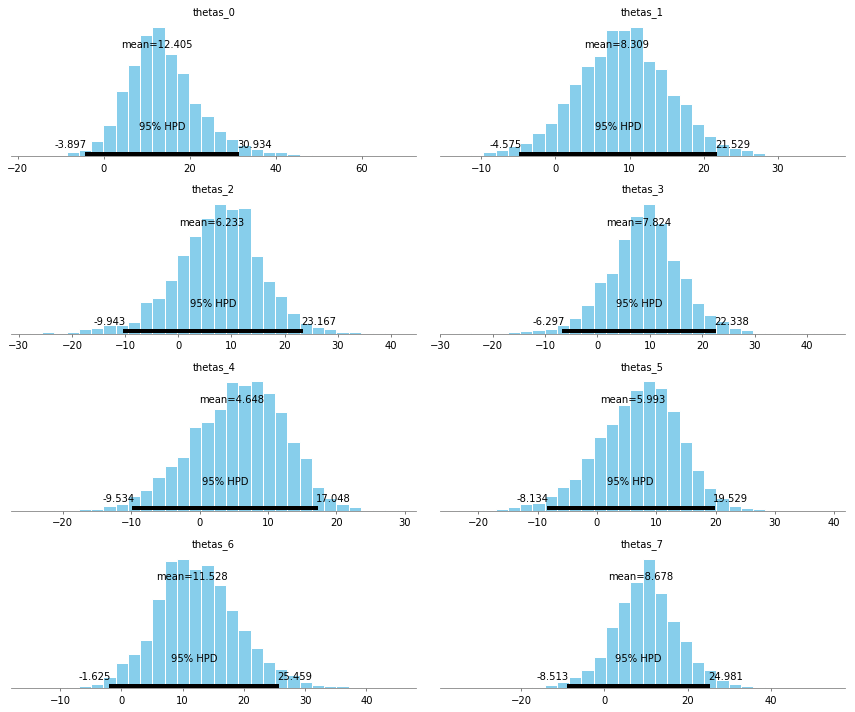

In [45]:
pm.plot_posterior(trace, varnames=['thetas']);